# **<h1><center> Production EDA </center></h1>**

### Description: 
- With Python, SQL and Plotly are used to generate high-level views on oil production from wells in the Williston Basin of North Dakota. The performance of these wells are governed by two primary sets of factors:

1) **Engineering:**
    - Factors under our control. These include depth and length of the well, where we place the well in the reservoir, how we stimulate the well (pumping fluid and proppant in to create fractures), and how closely we place multiple wells together (too close and they compete with one another, too far and we risk leaving resource behind). These features are best viewed in tabular format.
    

2) **Geologic:**
    - Factors outside of our control but measurable. Parameters such as pressure, thickness, porosity/permeability, saturations (oil/gas/water), stress, natural fracturing, etc. The primary geologic drivers change for different parts of the basin and are very much a topic of interpretation. These variables are best viewed spatially on a map, not in tabular format.


- We don’t have any traditional geologic variables to work with here, nor do we have the information on how the wells were stimulated. We will have to be creative and work with what we have to generate features that approximate this missing data!

### Data Context:
- The data we are working with here was scraped from a webpage and stored in a SQLite3 database. For those unfamiliar with these oil and gas data types, I hope to provide some context. We will be working with 2 tables:

1) **Header Table**
    - Contains general information about a well such as depth and location. It also contains the UWI (unique well identifier). There is a row for every well, leaving us with ~15,000 records.

2) **Production Table (Time-Series)**
    - Wells produce oil, water, and gas over time. This is our time-series data, which is why it is held in a separate table. Each of our ~15,000 wells have multiple records in this table, making is significantly larger at around 1.1 million rows. This table contains the UWI, the time stamp, the number of days that well actually flowed for that month, and the coinciding volumes for oil/water/gas.



# <center> ---------------------------------------------------------- </center>

## Import Packages

In [5]:
import pandas as pd
import sqlite3
import plotly.io as pio
import numpy as np
pd.set_option('display.max_columns', None)
from statistics import mean 
import folium
import branca.colormap as cm
import plotly.express as px
import plotly.graph_objects as go
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows",1000)
pd.options.display.precision = 1

### Connect to SQlite3 DataBase

In [6]:
%load_ext sql
%sql sqlite:////Users/john.odonnell/Python/Web_Scraping/NDIC/Well_DataBase.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### View Tables

In [7]:
%%sql 

SELECT 
    name 
FROM sqlite_master 
WHERE type ='table';

 * sqlite:////Users/john.odonnell/Python/Web_Scraping/NDIC/Well_DataBase.db
Done.


[('prod_table',),
 ('header_table',),
 ('prod_table_clean',),
 ('header_table_clean',)]

## Import Production data

In [8]:
# Create Query
query = %sql SELECT * FROM prod_table_clean WHERE Days > 0 and WOR between 0.01 and 10

# Create DataBase from query
df_production = query.DataFrame()

# Set index, cast date
df_production.set_index('UWI',inplace=True)
df_production['Date'] = pd.to_datetime(df_production['Date'], infer_datetime_format=True)

# View results
display(df_production.head(1))
df_production.describe().transpose()

 * sqlite:////Users/john.odonnell/Python/Web_Scraping/NDIC/Well_DataBase.db
Done.


Date   Days  Oil_nrm  Water_nrm   Gas_nrm  Fluid_nrm  \
UWI                                                                         
33007011630000 1992-04-01 30.000 6082.509    126.151 21841.118   6208.660   

                 WOR   GOR  
UWI                         
33007011630000 0.021 3.591

count     mean       std   min      25%      50%      75%  \
Days      1129275.000   27.823     5.961 1.000   28.000   30.000   31.000   
Oil_nrm   1129174.000 3774.952  9974.692 0.841 1059.138 1990.451 3990.631   
Water_nrm 1129174.000 3353.725  9599.008 0.676  781.795 1619.656 3380.515   
Gas_nrm   1129174.000 6123.632 26858.564 0.000 1380.402 2888.032 6061.617   
Fluid_nrm 1129174.000 7128.677 18466.010 1.682 2184.394 3857.531 7397.863   
WOR       1129275.000    1.165     1.123 0.010    0.435    0.854    1.517   
GOR       1129275.000    1.927     7.082 0.000    0.877    1.372    2.208   

                  max  
Days           31.000  
Oil_nrm   3446710.526  
Water_nrm 2614736.842  
Gas_nrm   7422894.737  
Fluid_nrm 5155263.158  
WOR            10.000  
GOR          4997.000

## Import Header data

In [9]:
# Create query
query = %sql SELECT * FROM header_table_clean

# Create DataBase from query
df_header = query.DataFrame()

# Set Index, cast dates
df_header.set_index('UWI',inplace=True)
df_header[['Completion_Date','Spud_Date']] = df_header[['Completion_Date','Spud_Date']].apply(pd.to_datetime, errors='coerce')

# View results
df_header.sample(3)

 * sqlite:////Users/john.odonnell/Python/Web_Scraping/NDIC/Well_DataBase.db
Done.


Well_Name  Latitude  Longitude  \
UWI                                                          
33053043670000  CAROL J A 5200 14-29T    47.963   -103.501   
33061016190000   SAUGER FEDERAL 2-22H    47.977   -102.305   
33053038260000         CORA 20-17 #1H    47.878   -103.513   

                                 Current_Operator Completion_Date Total_Depth  \
UWI                                                                             
33053043670000  OASIS PETROLEUM NORTH AMERICA LLC      2013-03-29       20810   
33061016190000  SLAWSON EXPLORATION COMPANY, INC.      2011-11-17       14060   
33053038260000                  EQUINOR ENERGY LP      2012-07-01       20800   

                Spud_Date Perf_Interval  Cum_Oil  Cum_Gas  Cum_Water  \
UWI                                                                    
33053043670000 2012-10-14   11204-20810   240649   325597     211973   
33061016190000 2011-09-08    9729-14060   379650   504494      47992   
33053038260000 2012-01-07   11303-20800   272286   447754     352794   

                Vintage_Year  Top_Perf  Bottom_Perf  Perforated_Length  \
UWI                                                                      
33053043670000      2013.000 11204.000    20810.000           9606.000   
33061016190000      2011.000  9729.000    14060.000           4331.000   
33053038260000      2012.000 11303.000    20800.000           9497.000   

               Section Township Range   Block  12m_Oil_nrm_cum  12m_WOR  \
UWI                                                                       
33053043670000      29      152   100  152100       105350.000    1.168   
33061016190000      22      152    91   15291       385451.000    0.067   
33053038260000      20      151   100  151100       113026.000    2.941   

                24m_Oil_nrm_cum  24m_WOR  36m_Oil_nrm_cum  36m_WOR  
UWI                                                                 
33053043670000       145772.000    0.759       174768.000    1.429  
33061016190000       541012.000    0.099       634170.000    0.120  
33053038260000       157217.000    1.281       196117.000    1.892

## High-Level Data QC
- Lets look at production

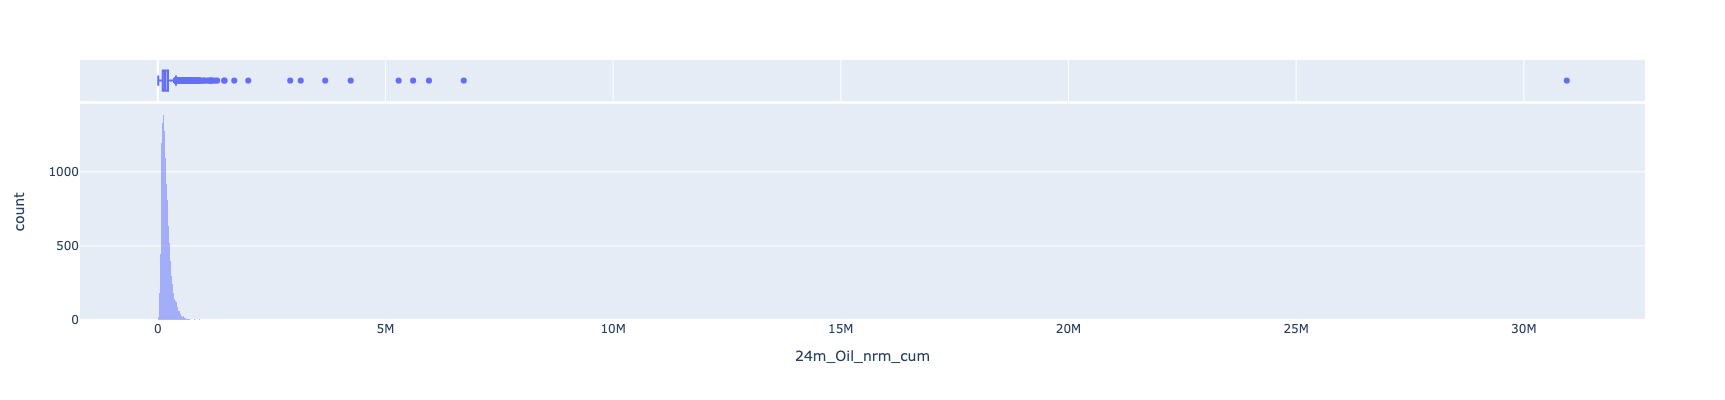

In [10]:
# Look at distribution of performance
px.histogram(df_header, x='24m_Oil_nrm_cum', 
             #color = 'Vintage_Year', 
             barmode = 'overlay', marginal = 'box', 
             height = 400, width = 700)

In [11]:
# Eliminate unreasonable values
df_header = df_header[(df_header['24m_Oil_nrm_cum'] < 800000) | (df_header['24m_Oil_nrm_cum'].isnull())]
df_header = df_header[(df_header['24m_WOR'] < 10) | (df_header['24m_WOR'].isnull())]

# <center> ------------------------- Mapping ------------------------- </center>

## What does the basin look like?
- Here we will plot our wells on a map, colored by the depth of the top perforation. The top perf on a well is typically within ~100’ of entering the formation, with this in mind we can use this perf depth as a proxy for formation depth.

In [ ]:
# Create DataFrame of values to plot
df_structure = df_header[df_header['Top_Perf'] > 9000]

# Create map
map_visual = folium.Map(location=(df_structure['Latitude'].mean(), df_structure['Longitude'].mean()),
                        zoom_start = 8, width = 500, height = 700)

# Specify feature to color by
color_by = 'Top_Perf'

# Create color map
colormap = cm.LinearColormap(colors=['black','gray','green','yellow','orange','red','darkviolet'], vmin=9000, vmax= 11600)

# Loop through each well in DataFrame, create circle, add to map
for uwi in df_structure.index:
    folium.Circle(
        location=[df_structure.loc[uwi]['Latitude'], df_structure.loc[uwi]['Longitude']],
        radius = 1100,
        fill = True,
        fill_opacity = 1,
        color = colormap(df_structure.loc[uwi][color_by])
    ).add_to(map_visual)
    
# Add colorbar
colormap.caption = 'Top_Perf'
map_visual.add_child(colormap)

# View
map_visual

- Looking at our map above it appears our assumption holds! The Williston basin has one structural feature that stands out from the others, the Nesson Anticline, which I have annotated here below!

## What are the most prolific areas?

In [ ]:
# Create DataFrame of values to plot
df_prodmap = df_header[df_header['24m_Oil_nrm_cum'].between(1,800000)]

# Create map
map_visual = folium.Map(location=(df_prodmap['Latitude'].mean(), df_prodmap['Longitude'].mean()),
                        zoom_start = 8, width = 500, height = 700)

# Specify feature to color by
color_by = '24m_Oil_nrm_cum'

# Create color map
colormap = cm.LinearColormap(colors=['black','gray','green','yellow','orange','red','darkviolet'], vmin=0, vmax= 500000)

# Loop through each well in DataFrame, create circle, add to map
for uwi in df_prodmap.index:
    folium.Circle(
        location=[df_prodmap.loc[uwi]['Latitude'], df_prodmap.loc[uwi]['Longitude']],
        radius = 1100,
        fill = True,
        fill_opacity = 1,
        color = colormap(df_prodmap.loc[uwi][color_by])
    ).add_to(map_visual)
    
# Add colorbar
colormap.caption = 'Top_Perf'
map_visual.add_child(colormap)

# View
map_visual

- Looking at this map, you could argue there are some trends in some areas, but its difficult to see
- There are many other factors at play here other than the geology
    - These are our engineering factors

## What are the most prolific blocks?

##### Group by Blocks
- Find mean oil and WOR

In [29]:
df_blocks = pd.DataFrame()

df_blocks['num_wells_block'] = df_header.groupby('Block')['Block'].count()
df_blocks['12m_oil_cum_block'] = df_header.groupby('Block')['12m_Oil_nrm_cum'].mean().astype(int)
df_blocks['12m_WOR_mean_block'] = df_header.groupby('Block')['12m_WOR'].mean()
df_blocks['24m_oil_mean_block'] = df_header.groupby('Block')['24m_Oil_nrm_cum'].mean().astype(int)
df_blocks['24m_WOR_mean_block'] = df_header.groupby('Block')['24m_WOR'].mean()

df_blocks.sort_values('24m_oil_mean_block',inplace=True, ascending=False)

df_blocks.head()

num_wells_block  12m_oil_cum_block  12m_WOR_mean_block  \
Block                                                            
15390                74             321526               0.347   
145101                5             254632               0.027   
15490                82             258183               0.342   
15094               105             266044               0.653   
15291               123             233087               0.432   

        24m_oil_mean_block  24m_WOR_mean_block  
Block                                           
15390               457503               0.470  
145101              398787               0.006  
15490               375836               0.538  
15094               339532               0.606  
15291               337344               0.388

### Add Block aggregated metrics to wells (with lat/longs) for a plot

In [30]:
df_header_blocks = df_header.merge(df_blocks, left_on = 'Block', right_index=True)

# Map

In [ ]:
df_map = df_header_blocks.copy()

# Create map
map_visual = folium.Map(location=(df_map['Latitude'].mean(), df_map['Longitude'].mean()), zoom_start = 8, width = 500, height = 700)

# Specify feature to color by
color_by = '24m_oil_mean_block'

# Create color map
colormap = cm.LinearColormap(colors=['black','gray','green','yellow','orange','red','darkviolet'], vmin=60000, vmax= 400000)

# Loop through each well in DataFrame, create circle, add to map.
for uwi in df_map.index:
    folium.Circle(
        location=[df_map.loc[uwi]['Latitude'], df_map.loc[uwi]['Longitude']],
        radius = 1250,
        popup = df_map.loc[uwi]['Block'],
        fill = True,
        fill_opacity = 1,
        color = colormap(df_map.loc[uwi][color_by])
    ).add_to(map_visual)
    
# Add colorbar
colormap.caption = 'Top_Perf'
map_visual.add_child(colormap)

# View
map_visual

# Production Box Plots

### Cumulative Oil

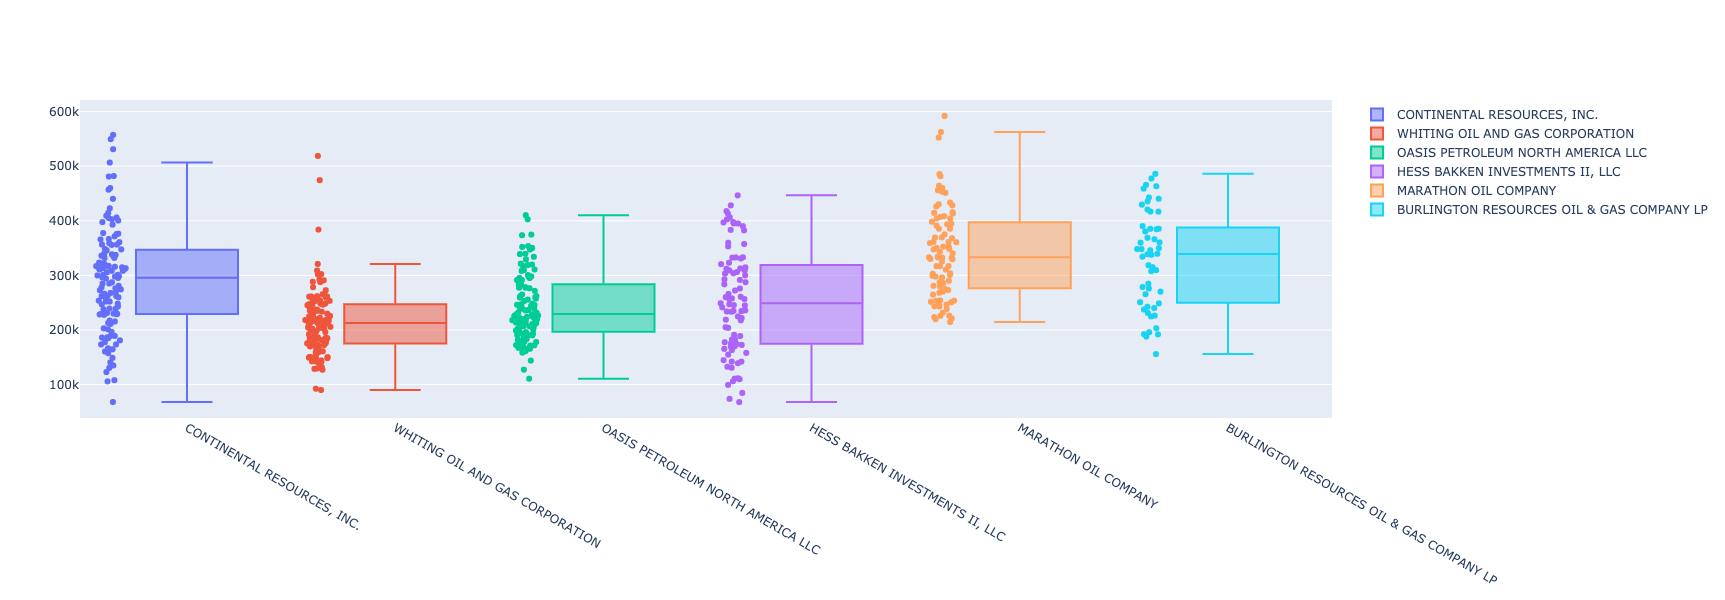

In [12]:
df_prod = df_production.copy()
df_head = df_header.copy()

df_head = df_head[df_head['Vintage_Year'] == 2018]

top_5_operators = df_head['Current_Operator'].value_counts().keys()[:6]

fig = go.Figure(layout={'height':600,'width':1100})


for operator in top_5_operators:
    fig.add_trace(go.Box(y = df_head[df_head['Current_Operator'] == operator]['24m_Oil_nrm_cum'], name=operator))

fig.update_traces(boxpoints='all', jitter=.3 )
fig

### WOR

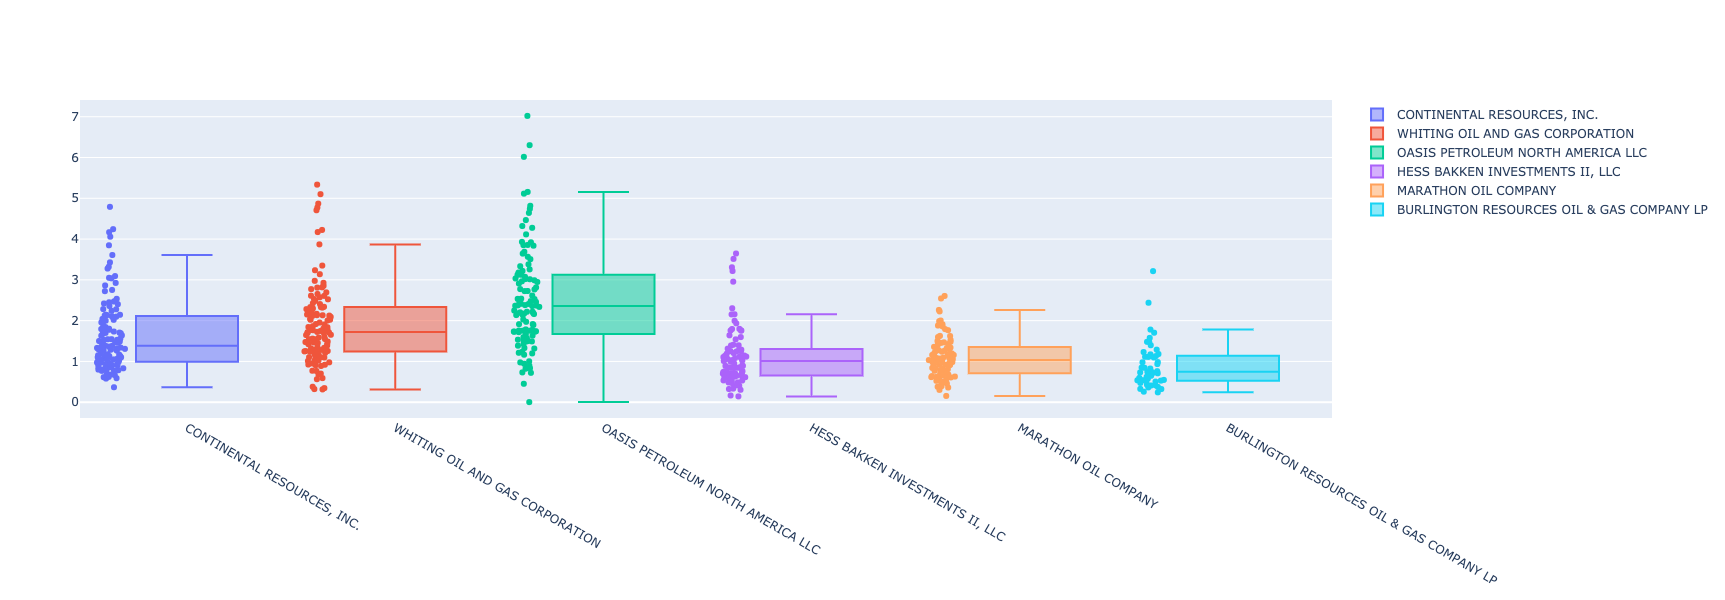

In [13]:
df_prod = df_production.copy()
df_head = df_header.copy()

df_head = df_head[df_head['Vintage_Year'] == 2018]

top_5_operators = df_head['Current_Operator'].value_counts().keys()[:6]

fig = go.Figure(layout={'height':600,'width':1100})


for operator in top_5_operators:
    fig.add_trace(go.Box(y = df_head[df_head['Current_Operator'] == operator]['24m_WOR'], name=operator))

fig.update_traces(boxpoints='all', jitter=.3 )
fig

# <center> ------------------------- Plotting production Streams ------------------------- </center>

## Define Function

In [15]:
def STREAM_PLOT(dataframe, production_dataframe, material, width, height, variable_dict = {'0-99999999':None}, rate_cum = 0, averages = 0, cumulative = 1,
                variable = df_header.select_dtypes(include=['float64']).iloc[:,0].name):
    
    fig = go.Figure(layout={'height':height,'width':width})
    
    if averages == 1:
        fig.update_layout(xaxis_title="Producing Days")
        for item in variable_dict.keys():
            low = float(item.split('-')[0])
            high = float(item.split('-')[1]) 
            df_temp = dataframe[dataframe[variable].between(low,high)]
            if len(df_temp) >= 1:     
                
                if material in ['WOR','GOR']:
                    average_list = []
                    for m in [i for i in range(1,27,1)]:
                        prod_list = []
                        for uwi in df_temp.index:  
                            try:
                                cum_day_list = production_dataframe.loc[uwi,'Days'].cumsum()
                                if m * 30.4 < max(cum_day_list):                                              
                                    rate_prod_list = production_dataframe.loc[uwi,material]
                                    prod_list.append(np.interp( m*30.4 , cum_day_list , rate_prod_list)) 
                                    name = f"Monthly {material}"
                            except: None
                        try:
                            average_list.append(mean(prod_list))
                        except: None
                    fig.update_layout(yaxis_title=name)
                    fig.add_trace(go.Scatter(x=[i*30.4 for i in range(1,27,1)], y=average_list, mode='lines',name=f'{item} Average', line=dict(color=variable_dict[item], width=6)))

                elif rate_cum == 0:        
                    average_list = []
                    for m in [i for i in range(1,27,1)]:
                        prod_list = []
                        for uwi in df_temp.index:  
                            try:
                                cum_day_list = production_dataframe.loc[uwi,'Days'].cumsum()
                                if m * 30.4 < max(cum_day_list):
                                    if cumulative == 1:
                                        cum_prod_list = production_dataframe.loc[uwi,material].cumsum()
                                        prod_list.append(np.interp( m*30.4 , cum_day_list , cum_prod_list))
                                        name = f"Cumulative {material} bbl"
                                    else:                 
                                        rate_prod_list = production_dataframe.loc[uwi,material]
                                        prod_list.append(np.interp( m*30.4 , cum_day_list , rate_prod_list)) 
                                        name = f"Monthly {material} bbl"
                            except:None
                        try:
                            average_list.append(mean(prod_list))
                        except:None
                    fig.update_layout(yaxis_title =name)
                    fig.add_trace(go.Scatter(x=[i*30.4 for i in range(1,27,1)], y=average_list, mode='lines',name=f'{item} Average', line=dict(color=variable_dict[item], width=6)))
            print(item,f'{len(df_temp)} wells')
            
    else:
        for item in variable_dict.keys():
            low = float(item.split('-')[0])
            high = float(item.split('-')[1]) 
            df_temp = dataframe[dataframe[variable].between(low,high)]
            if len(df_temp) >= 1:
                
                if material in ['WOR','GOR']:
                    for uwi in df_temp.index:
                        try:
                            day_list = production_dataframe.loc[uwi,'Days'].cumsum()
                            prod_list = production_dataframe.loc[uwi,material]
                            name = f"Monthy {material} Rate"
                            fig.add_trace(go.Scatter(x=day_list, y=prod_list, mode='lines',name=f"{dataframe.loc[uwi,'Well_Name']} ({dataframe.loc[uwi,'Current_Operator']})", line=dict(width=2,color=variable_dict[item])))
                        except: None
                    fig.update_layout(xaxis_title="Producing Days", yaxis_title=name)

                elif rate_cum == 1:        
                    for uwi in df_temp.index:
                        try:
                            rate_list = production_dataframe.loc[uwi,material]
                            cum_list = production_dataframe.loc[uwi,material].cumsum()
                            fig.update_yaxes(type='log')  
                            fig.add_trace(go.Scatter(x=cum_list, y=rate_list, mode='lines',name=f"{dataframe.loc[uwi,'Well_Name']} ({dataframe.loc[uwi,'Current_Operator']})", line=dict(width=2,color=variable_dict[item])))
                            fig.update_layout(xaxis_title= material+' Cum', yaxis_title =material+' Rate')
                        except: None

                elif rate_cum == 0:       
                    fig.update_layout(xaxis_title="Producing Days")
                    for uwi in df_temp.index:
                        try:
                            day_list = production_dataframe.loc[uwi,'Days'].cumsum()
                            if cumulative == 1:
                                prod_list = production_dataframe.loc[uwi,material].cumsum()
                                name = f"Cumulative {material} bbl"
                            else:
                                prod_list = production_dataframe.loc[uwi,material]
                                name = f"Monthy {material} bbl"
                                fig.update_yaxes(type='log')  
                            fig.add_trace(go.Scatter(x=day_list, y=prod_list, mode='lines',name=f"{dataframe.loc[uwi,'Well_Name']} ({dataframe.loc[uwi,'Current_Operator']})", line=dict(width=2,color=variable_dict[item])))
                            fig.update_layout(yaxis_title=name)
                        except: None

    return fig                         

# <center> Simple Stream Plots </center>

## Cumulative Oil vs. Time Plot

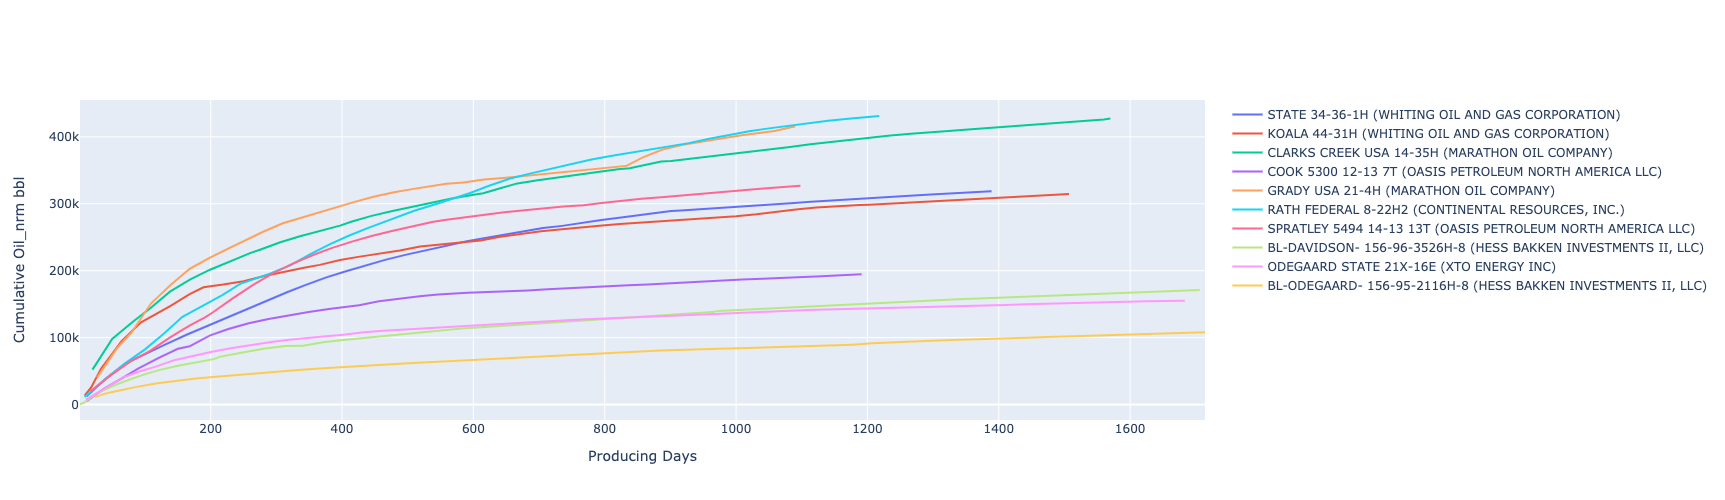

In [57]:
# Subset dataframe
df_head = df_header[(df_header['Vintage_Year'].between(2016,2017))].sample(10)

df_prod = df_production.copy()
# ---------------------------------------------------------
STREAM_PLOT(dataframe = df_head, 
            production_dataframe = df_prod[df_prod['WOR'].between(0.05, 8)], 
            material = 'Oil_nrm', 
            cumulative = 1, 
            width = 1000, height = 500)

## Oil Rate vs. Time Plot

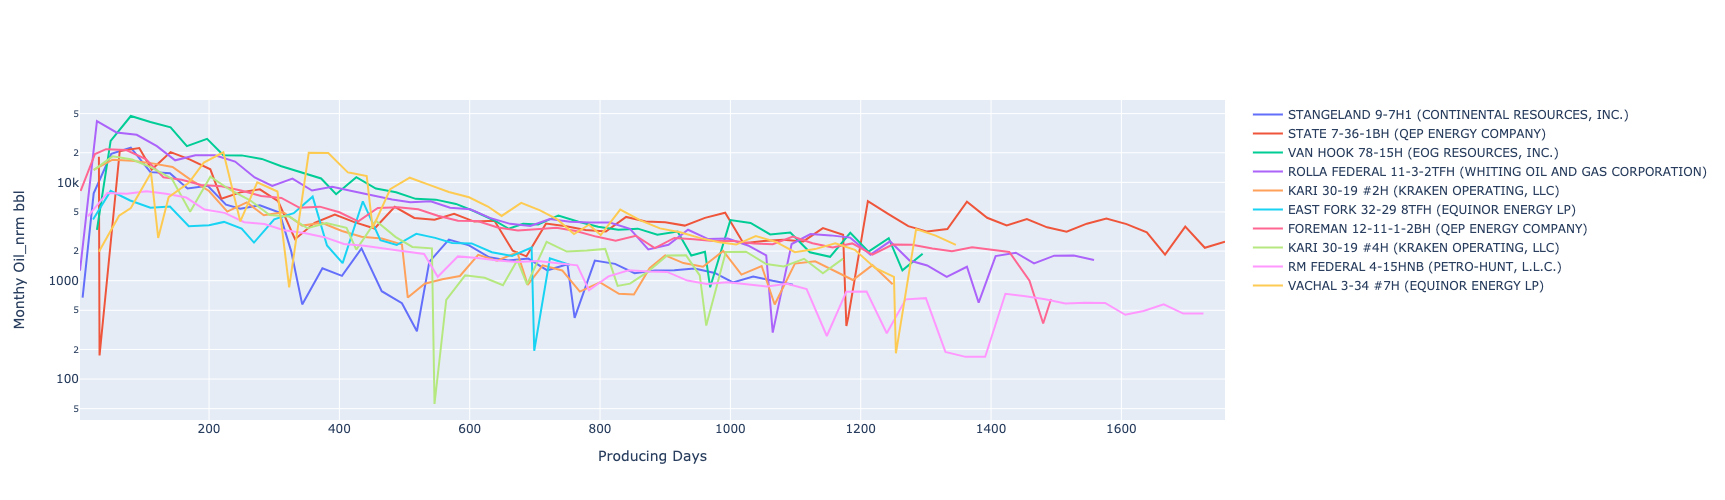

In [27]:
# Subset dataframe
df_head = df_header[(df_header['Vintage_Year'].between(2016,2017))].sample(10)

df_prod = df_production.copy()
# ---------------------------------------------------------
STREAM_PLOT(dataframe = df_head, 
            production_dataframe = df_prod[df_prod['WOR'].between(0.05, 8)], 
            material = 'Oil_nrm', 
            cumulative = 0, 
            width = 1000, height = 500)

## Oil Rate vs. Cumulative Plot

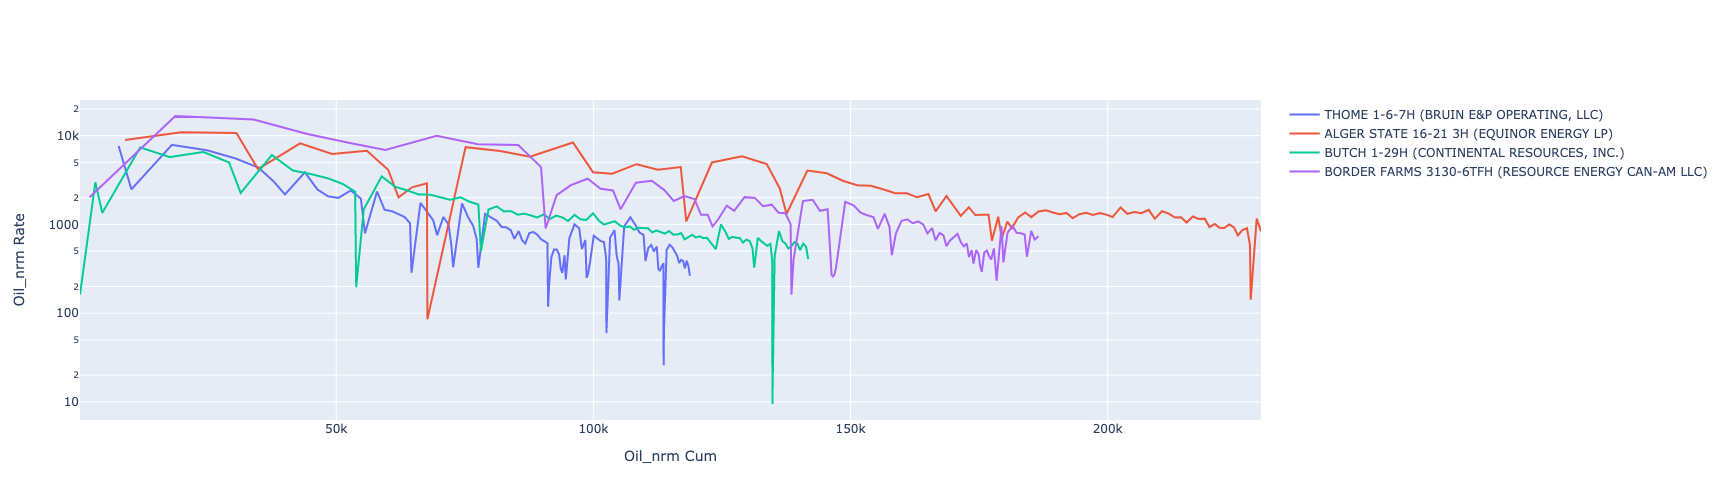

In [31]:
# Subset dataframe
df_head = df_header[(df_header['Vintage_Year'].between(2012,2012))].sample(4)

df_prod = df_production.copy()
# ---------------------------------------------------------
STREAM_PLOT(dataframe = df_head, 
            production_dataframe = df_prod[df_prod['WOR'].between(0.05, 8)], 
            material = 'Oil_nrm', 
            rate_cum= 1,
            cumulative = 1, 
            width = 1000, height = 500)

## Ratio Plots

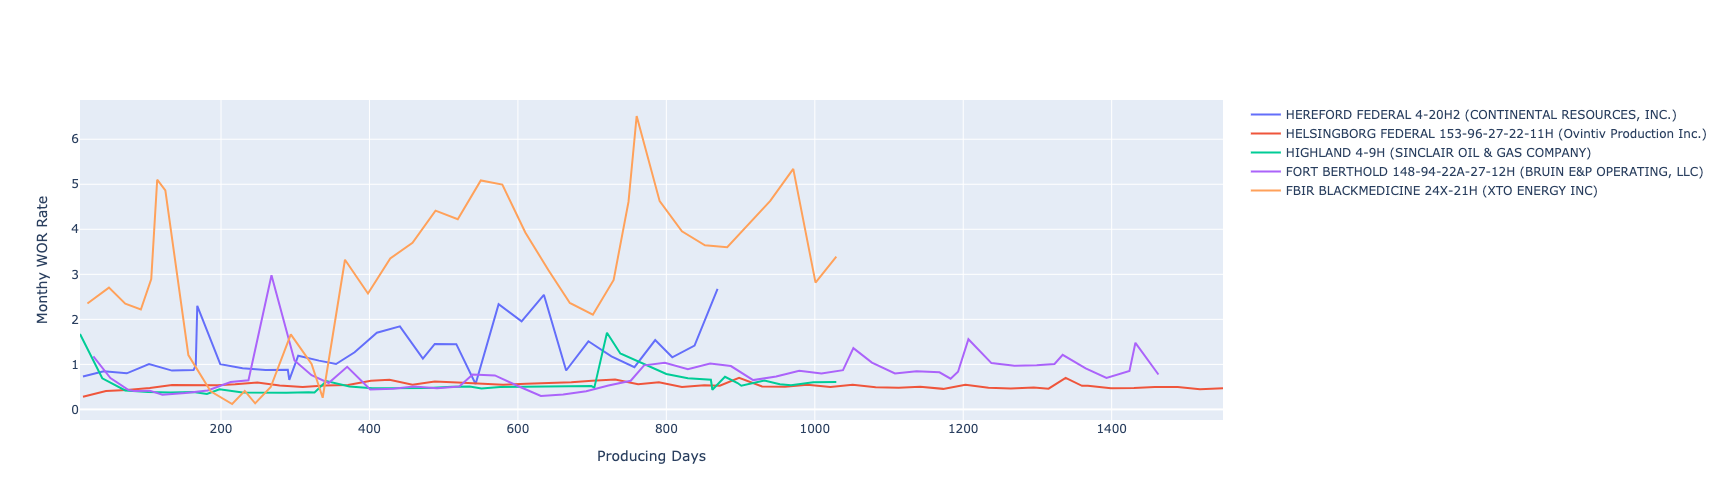

In [34]:
# Subset dataframe
df_head = df_header[(df_header['Vintage_Year'].between(2016,2017))].sample(5)

df_prod = df_production.copy()
# ---------------------------------------------------------
STREAM_PLOT(dataframe = df_head, 
            production_dataframe = df_prod[df_prod['WOR'].between(0.05, 8)], 
            material = 'WOR', 
            cumulative = 1, 
            width = 1000, height = 500)

# <center> Average Stream Plots </center>

## Water / Oil Ratio Plot

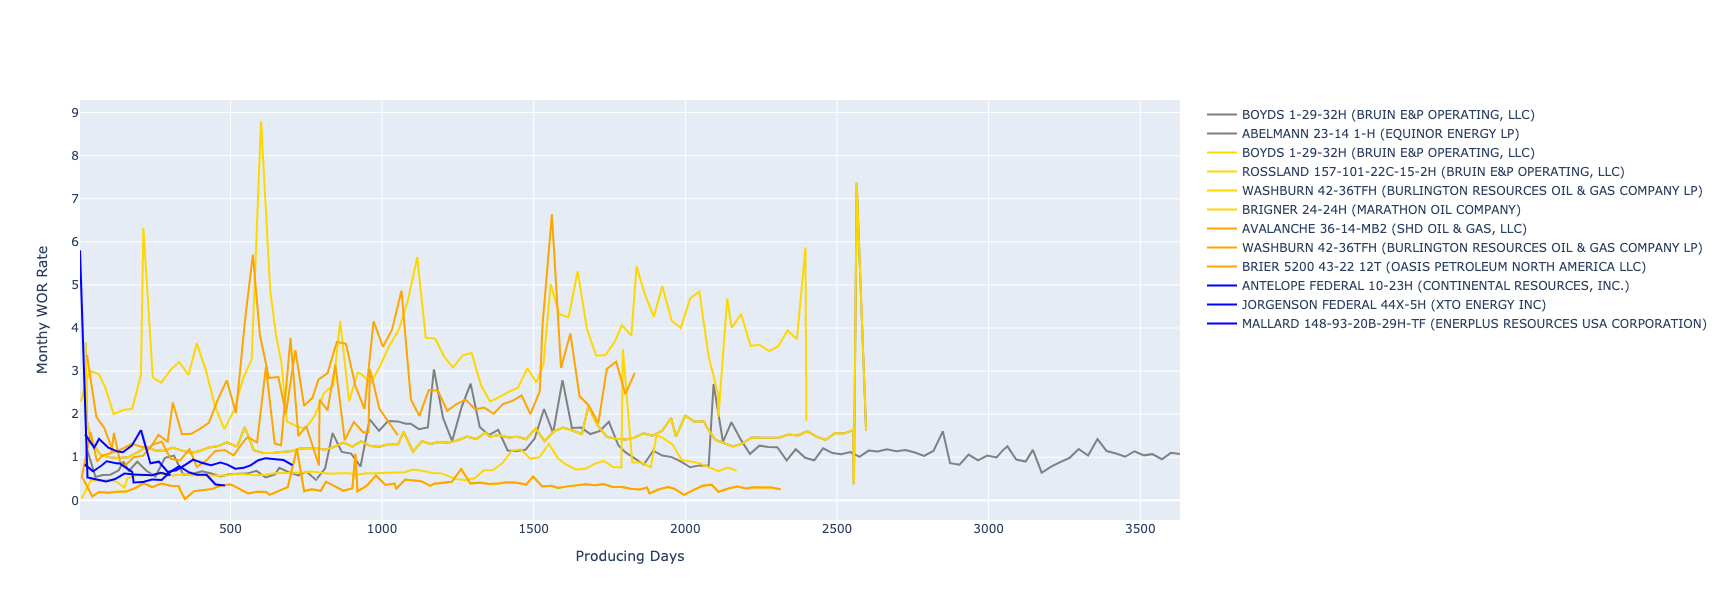

In [17]:
df_head = df_header[df_header['Vintage_Year'] > 2008].sample(1000)
df_prod = df_production[df_production['WOR'].between(0,10)]
# ---------------------------------------------------------
STREAM_PLOT(dataframe = df_head, 
            production_dataframe = df_prod, 
            material = 'WOR', 
            variable = 'Vintage_Year', 
            variable_dict = {'2008-2012':'grey',
                             '2012-2014':'gold',
                             '2014-2016':'orange',
                             '2016-2018':'red',
                             '2018-2020':'blue'},
            averages = 1,
            width = 800, height = 600 )

## Production by ~Depth / Pressure

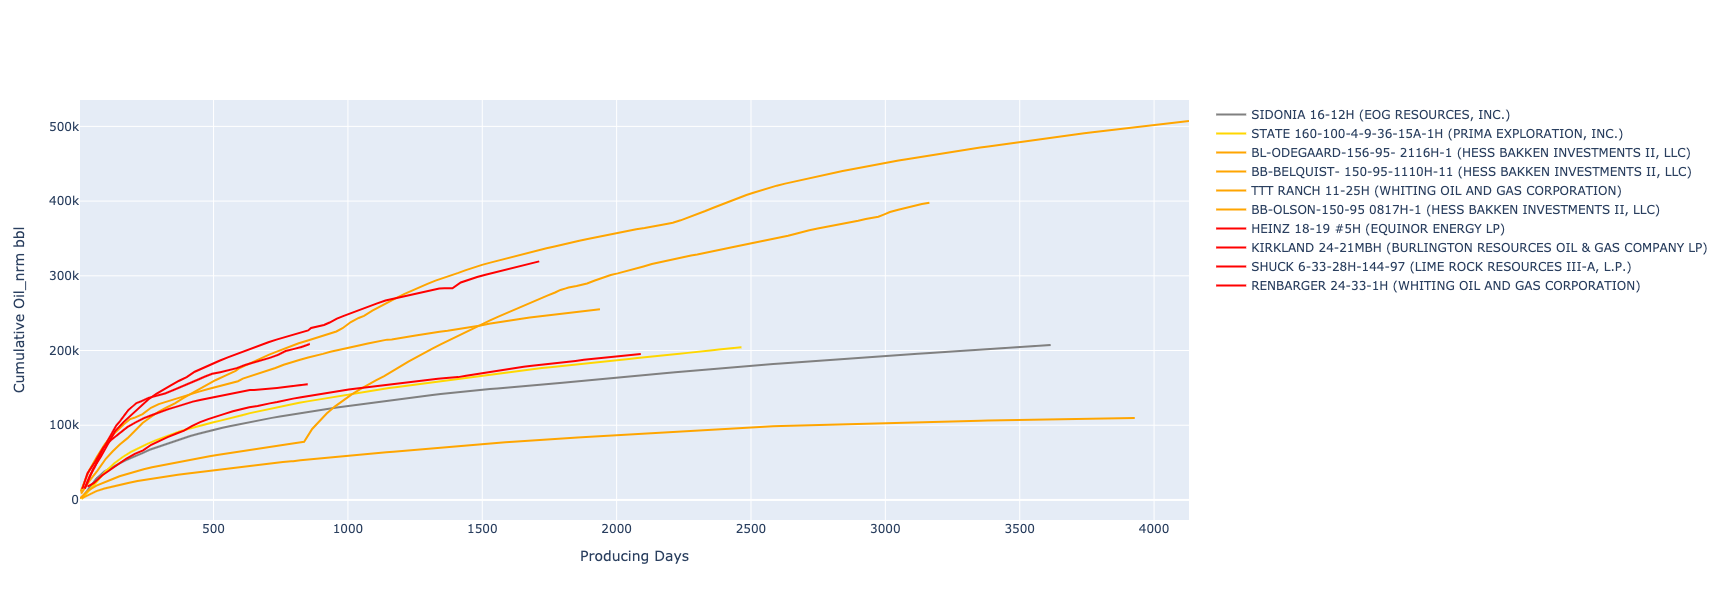

In [18]:
df_head = df_header.sample(5000)
df_prod = df_production.copy()
# ---------------------------------------------------------
STREAM_PLOT(dataframe = df_head, 
            production_dataframe = df_prod, 
            material = 'Oil_nrm', 
            cumulative = 1, 
            variable = 'Top_Perf', 
            variable_dict = {'0-9000':'grey',
                             '9000-10000':'gold',
                             '10000-11000':'orange',
                             '11000-12000':'red',
                             '12000-13000':'blue'},
            averages = 1,
            width = 800, height = 600)